In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# db = '/Volumes/Data/Spatial/OSM/CFO/2023-06-18/heights.gpkg'
# data = gpd.read_file(db, layer='buildings_stats_full2')

# db = '/Volumes/Data/Spatial/OSM/CFO/2023-06-18/buildings.gpkg'
db = '/Volumes/Data/Spatial/OSM/CFO/2023-06-18/buildings_2024-07-06.csv'
data_full = pd.read_csv(db)

/var/folders/5s/rkxr4m8j24569d_p6nj9ld200000gn/T/ipykernel_9795/3719676931.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_full = pd.read_csv(db)


In [6]:
# data.plot()
data_full.head()
len(data_full)

1417917

In [ ]:
num_cols = [
    'area',
    'isoquotient',
    'obox_ratio',
    'obox_hw',
    'h225med23_median', 
    # 'h425_median',
    # 'h1025_median',
    # 'w_median', 
    # 'w225_median', 
    # 'w425_median',
    # 'w1025_median'
    'width_median',
    'width1025_median',
]

cat_cols = [
    'building', 
    # 'lcz_majority', 
    'lcz225_majority', 
    # 'lcz425_majority',
    # 'lcz1025_majority'
]

feature_cols = num_cols + cat_cols
target_col = 'height'

In [9]:
data_full[cat_cols] = data_full[cat_cols].astype(str)
data_full.dtypes
na_count = data_full.isna().aggregate(sum)
na_count[na_count > 0] 
data = data_full.dropna()
len(data)

/var/folders/5s/rkxr4m8j24569d_p6nj9ld200000gn/T/ipykernel_9795/128034023.py:3: FutureWarning: The provided callable <built-in function sum> is currently using DataFrame.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  na_count = data_full.isna().aggregate(sum)


232451

In [11]:
import catboost
from sklearn.model_selection import train_test_split, GridSearchCV

X = data[feature_cols]
y = data[target_col]

X_train, X_valid, y_train, y_valid = train_test_split(X.values, y.values,
                                                    train_size=0.8,
                                                    random_state=22)

cat_indices = X.columns.get_indexer(cat_cols)

model = catboost.CatBoostRegressor(cat_features=cat_indices,
                                   loss_function='RMSE')

grid = {'iterations': [50, 100, 200, 400],
        'learning_rate': [0.025, 0.05, 0.1, 0.15],
        'depth': [8, 10, 12, 14],
        'l2_leaf_reg': [0.25, 0.5, 1]}

model.grid_search(grid, X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 19.0486047	test: 19.1939734	best: 19.1939734 (0)	total: 30.5ms	remaining: 1.49s
1:	learn: 18.7016746	test: 18.8438427	best: 18.8438427 (1)	total: 61.6ms	remaining: 1.48s
2:	learn: 18.3675698	test: 18.5065714	best: 18.5065714 (2)	total: 79.9ms	remaining: 1.25s
3:	learn: 18.0466477	test: 18.1821176	best: 18.1821176 (3)	total: 102ms	remaining: 1.18s
4:	learn: 17.7341653	test: 17.8669286	best: 17.8669286 (4)	total: 127ms	remaining: 1.14s
5:	learn: 17.4307379	test: 17.5610269	best: 17.5610269 (5)	total: 146ms	remaining: 1.07s
6:	learn: 17.1392426	test: 17.2674172	best: 17.2674172 (6)	total: 172ms	remaining: 1.06s
7:	learn: 16.8533140	test: 16.9788233	best: 16.9788233 (7)	total: 191ms	remaining: 1s
8:	learn: 16.5765539	test: 16.6995239	best: 16.6995239 (8)	total: 223ms	remaining: 1.02s
9:	learn: 16.3140619	test: 16.4348918	best: 16.4348918 (9)	total: 241ms	remaining: 965ms
10:	learn: 16.0573704	test: 16.1765256	best: 16.1765256 (10)	total: 274ms	remaining: 971ms
11:	learn: 15.80945

{'params': {'depth': 14,
  'learning_rate': 0.1,
  'l2_leaf_reg': 1,
  'iterations': 400},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

model.fit(X_train, y_train, cat_features=cat_indices)
model.score(X_train, y_train), model.score(X_valid, y_valid)

0:	learn: 14.0445245	total: 300ms	remaining: 1m 59s
1:	learn: 13.1501081	total: 598ms	remaining: 1m 59s
2:	learn: 12.3575656	total: 922ms	remaining: 2m 2s
3:	learn: 11.6616394	total: 1.24s	remaining: 2m 2s
4:	learn: 11.0786340	total: 1.5s	remaining: 1m 58s
5:	learn: 10.5583704	total: 1.82s	remaining: 1m 59s
6:	learn: 10.1006179	total: 2.15s	remaining: 2m
7:	learn: 9.7106573	total: 2.41s	remaining: 1m 58s
8:	learn: 9.3686622	total: 2.68s	remaining: 1m 56s
9:	learn: 9.0699895	total: 2.94s	remaining: 1m 54s
10:	learn: 8.8134677	total: 3.21s	remaining: 1m 53s
11:	learn: 8.5972128	total: 3.48s	remaining: 1m 52s
12:	learn: 8.4125667	total: 3.75s	remaining: 1m 51s
13:	learn: 8.2576384	total: 4.01s	remaining: 1m 50s
14:	learn: 8.1127141	total: 4.29s	remaining: 1m 50s
15:	learn: 7.9926489	total: 4.56s	remaining: 1m 49s
16:	learn: 7.8887416	total: 4.82s	remaining: 1m 48s
17:	learn: 7.7910474	total: 5.13s	remaining: 1m 48s
18:	learn: 7.7105675	total: 5.4s	remaining: 1m 48s
19:	learn: 7.6438434	to

(0.9131473607130781, 0.7743313125110864)

RMSE: 7.16
R2: 0.77


Text(0.5, 0, 'CatBoost Feature Importance')

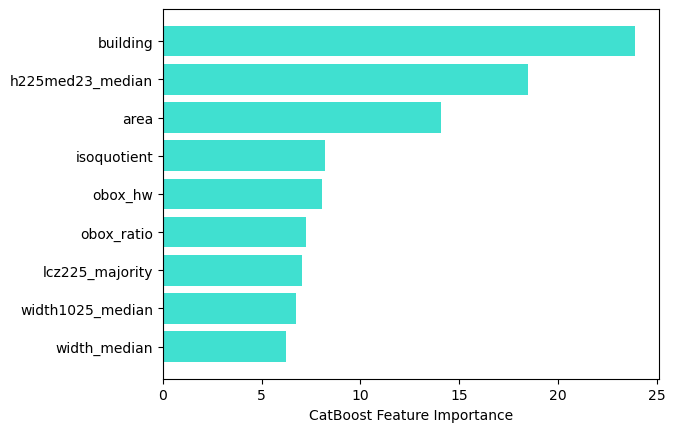

In [13]:
pred = model.predict(X_valid)
rmse = (np.sqrt(mean_squared_error(y_valid, pred)))
r2 = r2_score(y_valid, pred)

print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_feature_importance], 
         model.feature_importances_[sorted_feature_importance], 
         color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [32]:
data_pred = data_full[pd.isna(data_full['height'])]
data_pred_features = data_pred[feature_cols]

data_pred['height'] = model.predict(data_pred_features).round(0).astype(int)
data_pred['predicted'] = 1
data['predicted'] = 0

result = pd.concat([data, data_pred])
result.to_csv('/Volumes/Data/Spatial/OSM/CFO/2023-06-18/buildings_2024-07-06_predicted.csv')


/var/folders/5s/rkxr4m8j24569d_p6nj9ld200000gn/T/ipykernel_19214/2119096718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred['height'] = model.predict(data_pred_features).round(0).astype(int)
/var/folders/5s/rkxr4m8j24569d_p6nj9ld200000gn/T/ipykernel_19214/2119096718.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred['predicted'] = 1
/var/folders/5s/rkxr4m8j24569d_p6nj9ld200000gn/T/ipykernel_19214/2119096718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl